In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tabulate import tabulate




# 🧩 你的 DualStream_multihead 根目录
BASE_DIR = Path("/data4/huangweigang/gh/csiro-biomass/历史模型")

def show_detail(time_str, tail_window=10, epoch_num=None, min_epoch = 100, show_plot=False):
    exp_dir = BASE_DIR / time_str
    metrics_path = exp_dir / "fold_metrics.xlsx"

    # ===== 1️⃣ 加载文件 =====
    if not metrics_path.exists():
        print(f"❌ 未找到文件: {metrics_path}")
        return
    df = pd.read_excel(metrics_path)
    
    # print(f"\n\n✅ 已加载: {metrics_path}")
    print(f"📊 数据形状: {df.shape}  实验名称：{time_str}")
    fold_cnt = (df.shape[1] - 1) // 4 + 1
    folds = list(range(1, fold_cnt))
    print(folds)
    # folds = [1, 2, 3, 4, 5]
    least_limit = min_epoch

    # ===== 2️⃣ 初始化表格（包含平均行） =====
    summary_table = pd.DataFrame({
        "Fold": [f"Fold{f}" for f in folds] + ["Average"],
        "Best_Epoch": [np.nan]*fold_cnt,
        "Best_CV": [np.nan]*fold_cnt,
        "last20_CV": [np.nan]*fold_cnt,
        "last_CV": [np.nan]*fold_cnt
    })

    # ===== 3️⃣ 计算每折最佳结果（epoch >= 130） =====
    best_epochs, best_cvs = [], []
    for f in folds:
        col_cv = f"CV_Fold{f}"
        filtered_df = df[df["Epoch"] >= least_limit]
        best_idx = filtered_df[col_cv].idxmax()
        best_epochs.append(int(filtered_df.loc[best_idx, "Epoch"]))
        best_cvs.append(filtered_df.loc[best_idx, col_cv])

    # ===== 4️⃣ 最后 window 个 epoch 的平均 CV =====
    fold_window_means = []
    for f in folds:
        col = f"CV_Fold{f}"
        vals = df[col].dropna()
        if len(vals) >= tail_window:
            mean_val = vals.tail(tail_window).mean()
        elif len(vals) > 0:
            mean_val = vals.mean()
        else:
            mean_val = np.nan
        fold_window_means.append(mean_val)

    # ===== 5️⃣ 每个 Fold last_有效 epoch 的 CV =====
    fold_last_epoch_cv = []
    for f in folds:
        col = f"CV_Fold{f}"
        vals = df[col].dropna()
        last_epoch_cv = vals.iloc[-1] if len(vals) > 0 else np.nan
        fold_last_epoch_cv.append(last_epoch_cv)

    # ===== 6️⃣ 填充表格并计算平均 =====
    for i, f in enumerate(folds):
        summary_table.loc[i, "Best_Epoch"] = best_epochs[i]
        summary_table.loc[i, "Best_CV"] = best_cvs[i]
        summary_table.loc[i, "last20_CV"] = fold_window_means[i]
        summary_table.loc[i, "last_CV"] = fold_last_epoch_cv[i]

    summary_table.loc[len(folds), "Best_CV"] = np.nanmean(best_cvs)
    summary_table.loc[len(folds), "last20_CV"] = np.nanmean(fold_window_means)
    summary_table.loc[len(folds), "last_CV"] = np.nanmean(fold_last_epoch_cv)


    if not show_plot: 
        print(f"📊 CV统计汇总表（epoch ≥ {least_limit}）：  {time_str}")
        print(tabulate(summary_table, headers="keys", tablefmt="github", floatfmt=".5f"))
        print("\n")
        return summary_table


    # Create a figure with 4 subplots (4 rows, 1 column)
    fig, axes = plt.subplots(5, 1, figsize=(8, 12))

    # --- CV Curve ---
    sub_id = 0 
    axes[sub_id].set_title("CV Score per Fold (Epoch)")
    for f in folds:
        axes[sub_id].plot(df["Epoch"], df[f"CV_Fold{f}"], label=f"Fold{f}")
    if epoch_num is not None:
        axes[sub_id].axvspan(epoch_num - tail_window + 1, epoch_num,
                        color="yellow", alpha=0.2,
                        label=f"{epoch_num-tail_window+1}-{epoch_num}")
    axes[sub_id].set_xlabel("Epoch")
    axes[sub_id].set_ylabel("CV")
    axes[sub_id].legend()
    axes[sub_id].grid(True, linestyle="--", alpha=0.6)

    # --- Sliding Window Fluctuation ---
    sub_id = 1 
    axes[sub_id].set_title(f"Sliding CV Range (Window={tail_window} Epochs)")
    window_size = tail_window
    for f in folds:
        col = f"CV_Fold{f}"
        diffs, epochs = [], []
        for i in range(window_size - 1, len(df)):
            window = df[col].iloc[i - window_size + 1: i + 1]
            diffs.append(window.max() - window.min())
            epochs.append(df["Epoch"].iloc[i])
        axes[sub_id].plot(epochs, diffs, label=f"Fold{f}")
    axes[sub_id].set_xlabel("Epoch")
    axes[sub_id].set_ylabel("CV Range (Max-Min)")
    axes[sub_id].legend()
    axes[sub_id].grid(True, linestyle='--', alpha=0.7)

    # --- Train Loss Curve ---
    sub_id = 2 
    for f in folds:
        axes[sub_id].plot(df["Epoch"], df[f"Train_Fold{f}"], label=f"Train_Fold{f}")
    axes[sub_id].set_title("Train Loss per Fold")
    axes[sub_id].set_ylim([0,2])
    axes[sub_id].grid(True, linestyle='--', alpha=0.6)
    axes[sub_id].legend()

    # --- Validation Loss Curve ---
    sub_id = 3 
    for f in folds:
        axes[sub_id].plot(df["Epoch"], df[f"Val_Fold{f}"], label=f"Val_Fold{f}")
    axes[sub_id].set_title("Validation Loss per Fold")
    axes[sub_id].set_xlabel("Epoch")
    axes[sub_id].set_ylim([0,1])
    axes[sub_id].grid(True, linestyle='--', alpha=0.6)
    axes[sub_id].legend()




    # --- LR Curve ---
    sub_id = 4 
    for f in folds:
        axes[sub_id].plot(df["Epoch"], df[f"LR_Fold{f}"], label=f"LR_Fold{f}")
    axes[sub_id].set_title("LR per Fold")
    axes[sub_id].set_xlabel("Epoch")
    axes[sub_id].grid(True, linestyle='--', alpha=0.6)
    axes[sub_id].legend()

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Show the combined plot
    plt.show()

    # # ===== 8️⃣ 返回表格数据 =====
    # return summary_table


In [4]:
show_plot = False
table = show_detail('single_1209/single_1209', min_epoch = 0, show_plot=show_plot)
table = show_detail('single_1209/single_1209_2', min_epoch = 0, show_plot=show_plot)
table = show_detail('single_1209/single_1209_CLAHE', min_epoch = 0, show_plot=show_plot)
table = show_detail('single_1209/single_1209_CLAHE16', min_epoch = 0, show_plot=show_plot)
table = show_detail('single_1209/single_1209_ShadowAndGlare', min_epoch = 0, show_plot=show_plot)

📊 数据形状: (200, 21)  实验名称：single_1209/single_1209
[1, 2, 3, 4, 5]
📊 CV统计汇总表（epoch ≥ 0）：  single_1209/single_1209
|    | Fold    |   Best_Epoch |   Best_CV |   last20_CV |   last_CV |
|----|---------|--------------|-----------|-------------|-----------|
|  0 | Fold1   |     58.00000 |   0.79851 |     0.77996 |   0.77443 |
|  1 | Fold2   |     89.00000 |   0.87823 |     0.83039 |   0.83209 |
|  2 | Fold3   |     94.00000 |   0.81306 |     0.79816 |   0.79766 |
|  3 | Fold4   |    111.00000 |   0.81827 |     0.80906 |   0.80996 |
|  4 | Fold5   |     76.00000 |   0.81429 |     0.79048 |   0.78897 |
|  5 | Average |    nan       |   0.82447 |     0.80161 |   0.80062 |


📊 数据形状: (200, 21)  实验名称：single_1209/single_1209_2
[1, 2, 3, 4, 5]
📊 CV统计汇总表（epoch ≥ 0）：  single_1209/single_1209_2
|    | Fold    |   Best_Epoch |   Best_CV |   last20_CV |   last_CV |
|----|---------|--------------|-----------|-------------|-----------|
|  0 | Fold1   |     83.00000 |   0.80321 |     0.78360 |   0.77748 |
| 

📊 数据形状: (200, 21)  实验名称：single_1209/single_1209
[1, 2, 3, 4, 5]


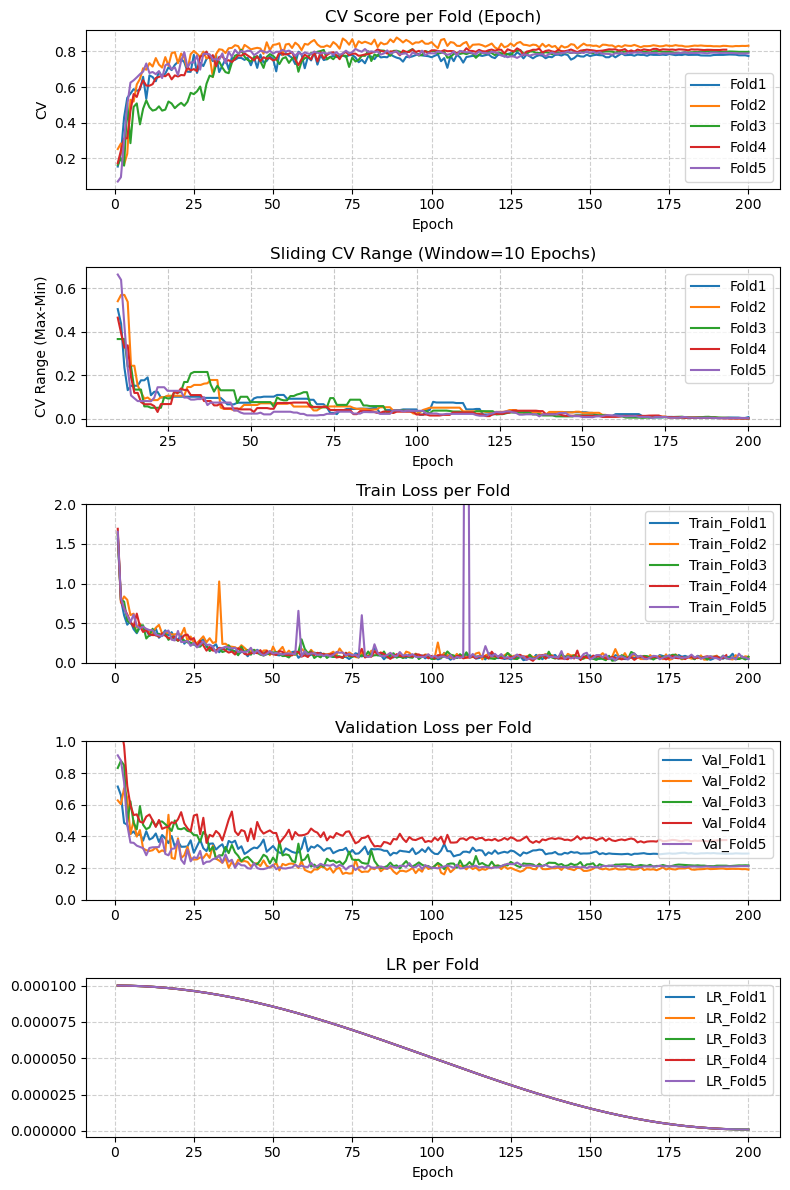

📊 数据形状: (200, 21)  实验名称：single_1209/single_1209_2
[1, 2, 3, 4, 5]


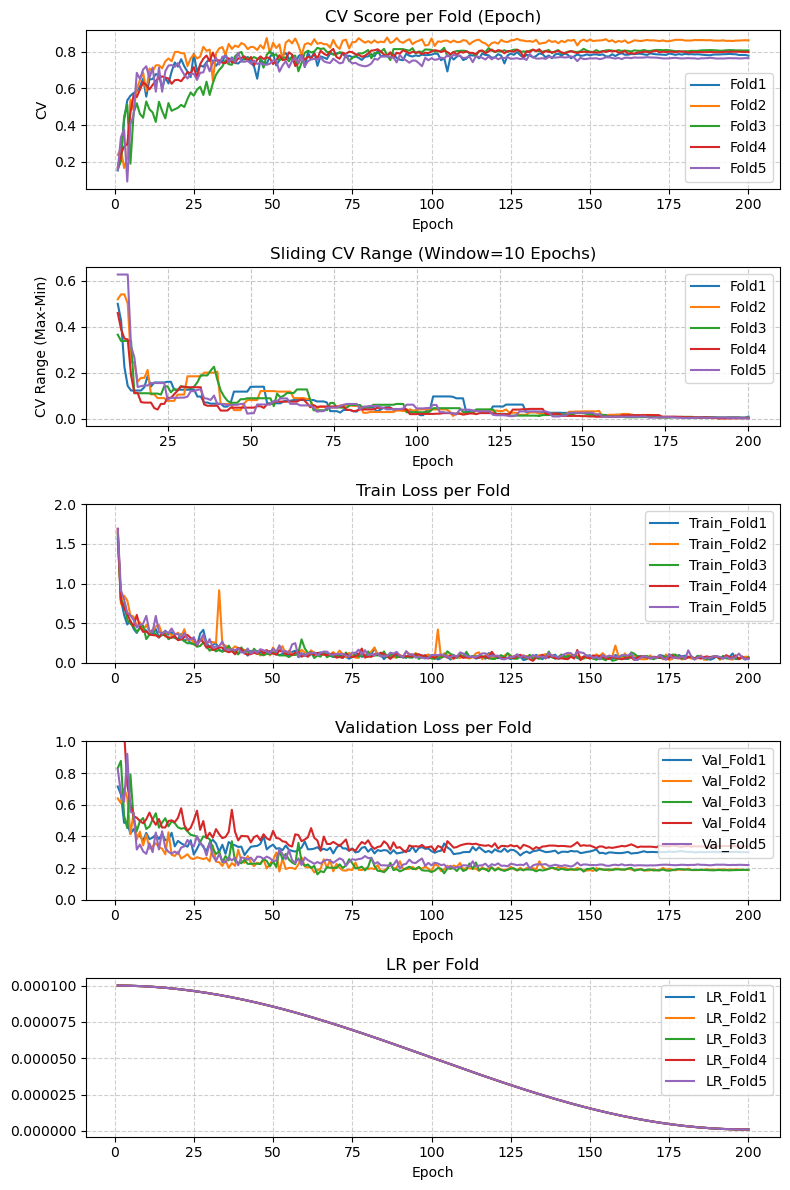

📊 数据形状: (200, 21)  实验名称：single_1209/single_1209_CLAHE
[1, 2, 3, 4, 5]


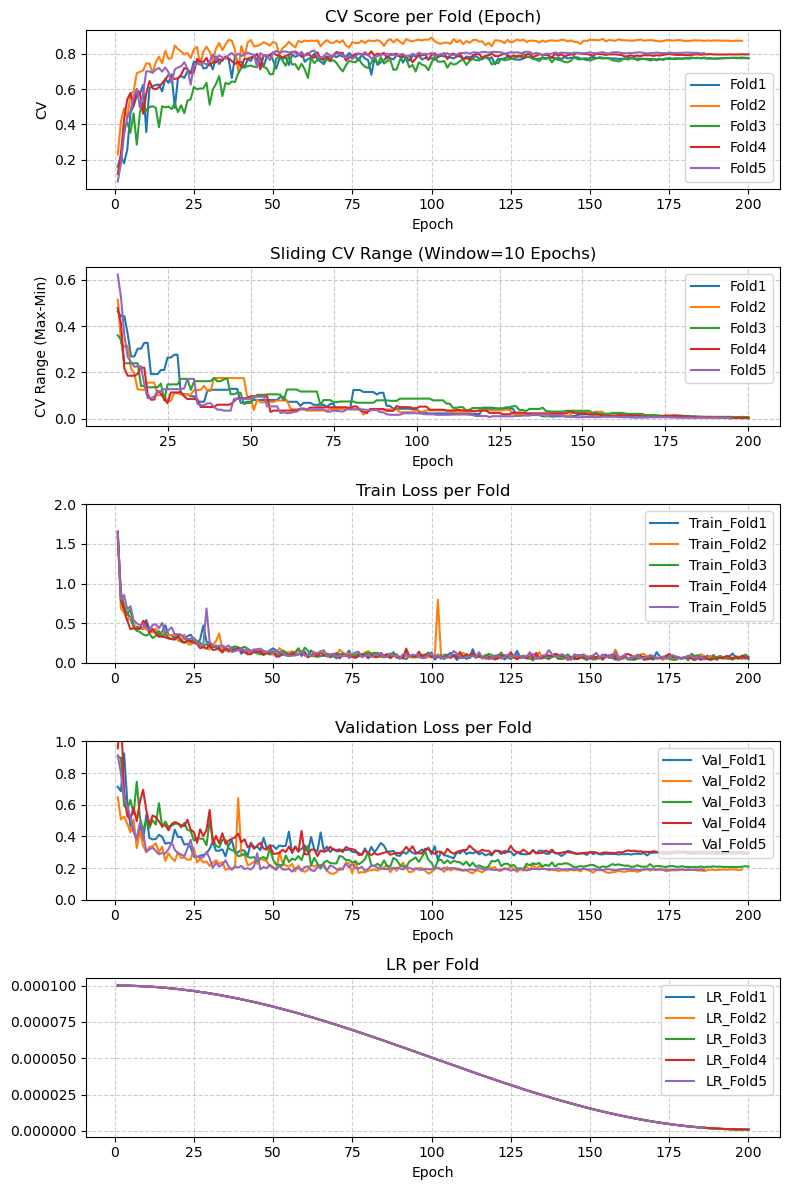

📊 数据形状: (200, 21)  实验名称：single_1209/single_1209_CLAHE16
[1, 2, 3, 4, 5]


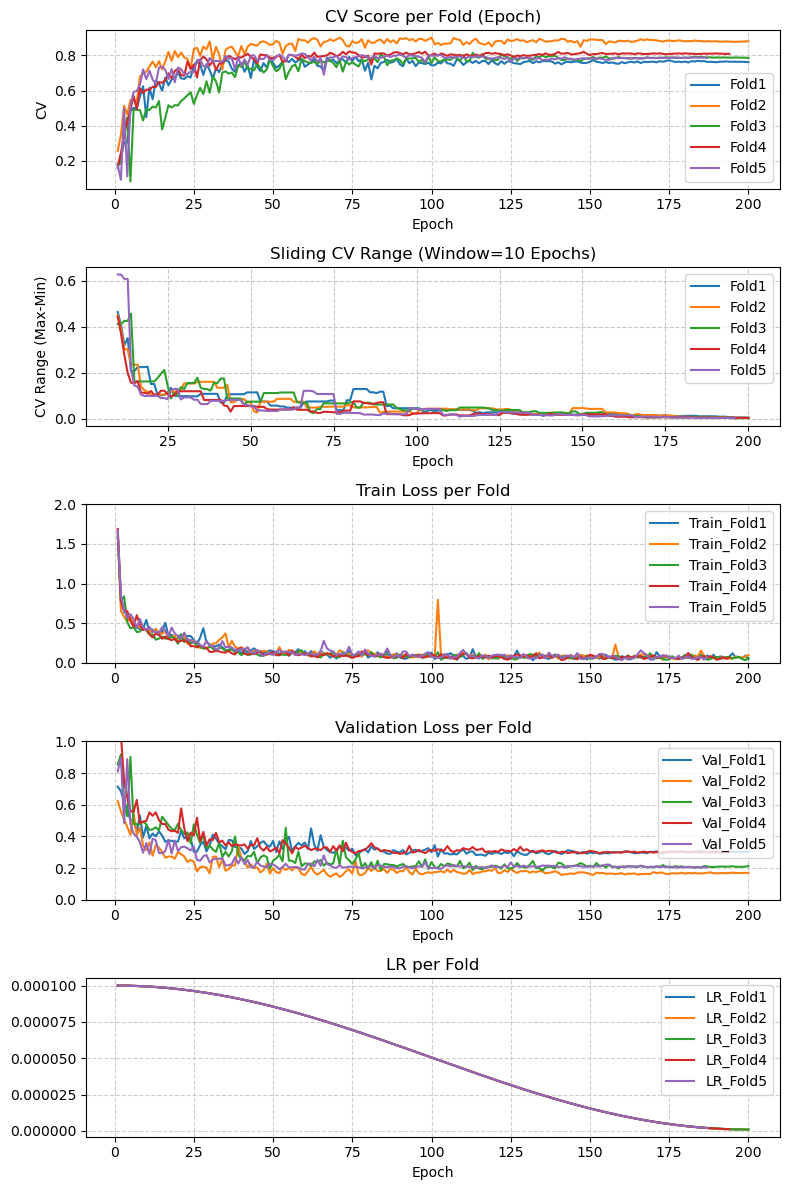

📊 数据形状: (200, 21)  实验名称：single_1209/single_1209_ShadowAndGlare
[1, 2, 3, 4, 5]


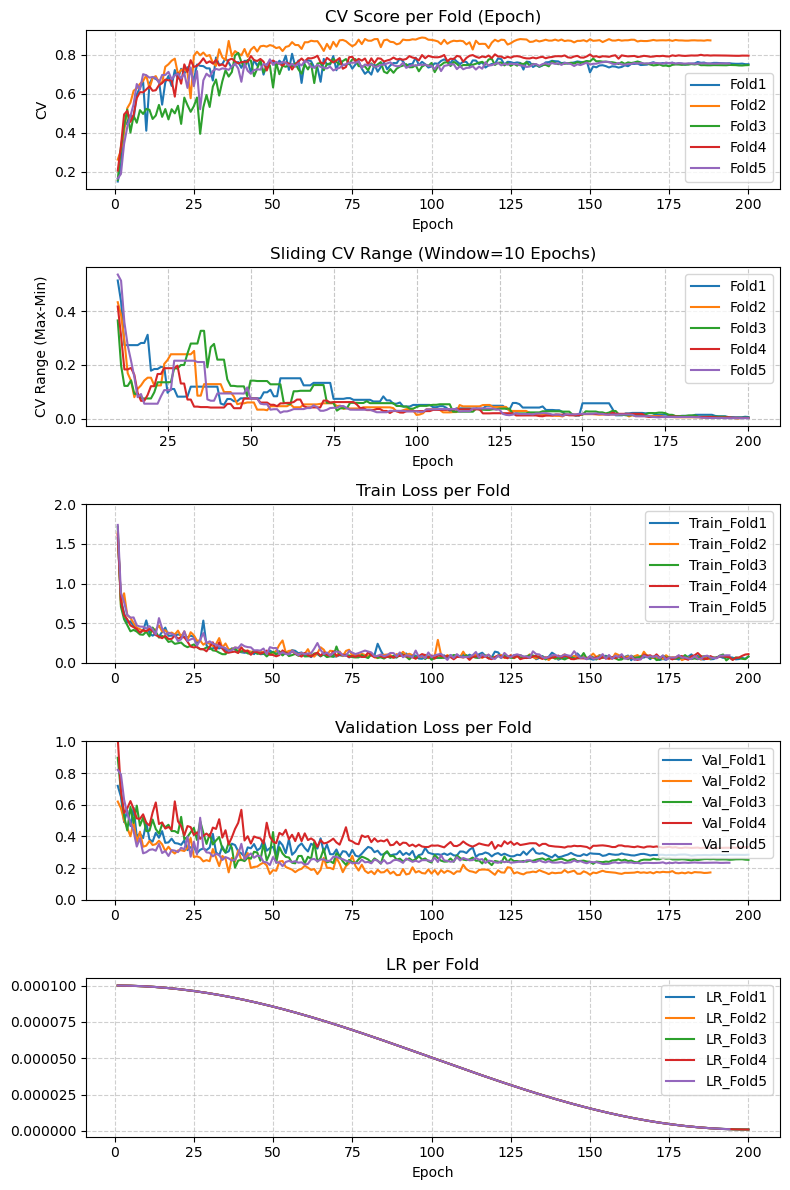

In [3]:
show_plot = True
table = show_detail('single_1209/single_1209', min_epoch = 0, show_plot=show_plot)
table = show_detail('single_1209/single_1209_2', min_epoch = 0, show_plot=show_plot)
table = show_detail('single_1209/single_1209_CLAHE', min_epoch = 0, show_plot=show_plot)
table = show_detail('single_1209/single_1209_CLAHE16', min_epoch = 0, show_plot=show_plot)
table = show_detail('single_1209/single_1209_ShadowAndGlare', min_epoch = 0, show_plot=show_plot)